# <center> Single compartment model using double exponentials</center>

## Summary

### 1. Setup and testing
The model is trying to simulate a single compartment,
$$ C_m \frac{dV_m}{dt} = g_{leak}(V_m - E_{leak}) + g_{exc}(V_m - E_{AMPA}) + g_{inh}(V_m - E_{GABA})$$ 
Here $E$'s are reversal potentials, $V_m$ is membrane potential, $g$'s are conductances, and $C_m$ is the membrane capacitance. 
The synaptic conductances are modeled as double exponentials: $$g(t) = \bar{g}\frac{( e^\frac{\delta_{onset} - t }{\tau_{decay}} - e^\frac{\delta_{onset} - t }{\tau_{rise}})}{- \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{decay}}{\tau_{decay} - \tau_{rise}}} + \left(\frac{\tau_{rise}}{\tau_{decay}}\right)^{\frac{\tau_{rise}}{\tau_{decay} - \tau_{rise}}}}$$
Here $\bar{g}$ is maximum conductance, $\tau$ and $\delta$ are time course and onset delay parameters respectively. The denominator is to normalize the term to 1. All the quantities in the model have been set up with sympy and have units.

In this notebook, later the model is tested by plotting excitatory and inhibitory PSPs with the parameters.

### 2. Exploring hypotheses

After setting up the model with reasonable parameters from literature or data, the following hypotheses are explored:

1. What can give rise to divisive normalization?
    1. No inhibition?
    2. Proportional excitation and inhibition?
    3. Divisive recruitment kinetics of inhibition? (Here g_i recruitment is a nonlinear function in g_e).
    4. Proportional excitation and inhibition, with delays as a function of excitation?

### 3. Still to be done:
1. Put a thresholding non-linearity and check spike times as a function of g_e.

___

In [1]:
from IPython.display import display, Markdown

In [2]:
# Parallelizing over the cores
import os
# import ipyparallel as ipp
# clients = ipp.Client()
# dview = clients.direct_view()
# print(clients.ids)

In [3]:
#with dview.sync_imports():
from sympy import symbols, exp, solve, logcombine, simplify, Piecewise, lambdify, N, init_printing, Eq
import numpy
#from sympy import *
from sympy.physics.units import seconds, siemens, volts, farads, amperes, milli, micro, nano, pico, ms, s, kg, meters
from matplotlib import pyplot as plt
#%px plt = pyplot

In [4]:
#dview.block=True

In [5]:
init_printing()

In [6]:
#matplotlib notebook
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,6)
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

#### Simulation time

In [7]:
samplingRate = 20  # kHz, to get milliseconds
sample_every = 1 # ms
timeStep, maxTime = (sample_every*1.)/ samplingRate, 100.  # ms
trange = numpy.arange(
    0., maxTime, timeStep)  # We will always use 100. ms timecourse of PSPs.

#### Range of $g_e$ explored

In [8]:
emax = 4
e_step = 0.1
erange = numpy.arange(0., emax, e_step)

#### Range of proportionality ($P$) between $E$ and $I$

In [9]:
prop_array = numpy.arange(1, 5, 1)

In [10]:
# dview.push(dict(trange=trange, erange=erange, prop_array=prop_array))

## Setting up the variables, parameters and units for simulation

In [11]:
t, P, e_r, e_d, delta_e, rho_e, g_e, i_r, i_d, delta_i, rho_i, g_i, b, Cm, g_L = symbols(
    't P \\tau_{er} \\tau_{ed} \\delta_e \\rho_e \\bar{g}_e \\tau_{ir} \\tau_{id} \\delta_i \\rho_i \\bar{g}_i \\beta C_m \\bar{g}_L',
    positive=True,
    real=True)

In [12]:
leak_rev, e_rev, i_rev, Vm = symbols(
    'Leak_{rev} Exc_{rev} Inh_{rev} V_m', real=True)

In [13]:
SymbolDict = {
    t: "Time (ms)",
    P: "Proportion of $g_i/g_e$",
    e_r: "Excitatory Rise (ms)",
    e_d: "Excitatory Fall (ms)",
    delta_e: "Excitatory onset time (ms)",
    rho_e: "Excitatory $tau$ ratio (fall/rise)",
    g_e: "Excitatory max conductance",
    i_r: "Inhibitory Rise (ms)",
    i_d: "Inhibitory Fall(ms)",
    delta_i: "Inhibitory onset time(ms)",
    rho_i: "Inhibitory $tau$ ratio (fall/rise)",
    g_i: "Inhibitory max conductance",
    b: "Inhibitory/Excitatory $tau$ rise ratio"
}

In [14]:
unitsDict = {
    's': seconds,
    'exp': exp,
    'S': siemens,
    'V': volts,
    'A': amperes,
    'm': meters,
    'kg': kg
}  # This is for lamdify

In [113]:
nS, pF, mV, pA = nano * siemens, pico * farads, milli * volts, pico*amperes

### Estimates from data and averaging them to get a number

In [16]:
estimateDict = {
    P: (1.9, 2.1),
    e_r: (1.5 * ms, 5 * ms),
    e_d: (8. * ms, 20. * ms),
    delta_e: (0. * ms, 0. * ms),
    rho_e: (2., 7.),
    g_e: (0.02 * nS, 0.25 * nS),
    i_r: (1.5 * ms, 5. * ms),
    i_d: (14. * ms, 60. * ms),
    delta_i: (2. * ms, 4. * ms),
    rho_i: (5., 20.),
    g_i: (0.04 * nS, 0.5 * nS),
    b: (0.5, 5.)
}

In [17]:
averageEstimateDict = {
    key: value[0] + value[1] / 2
    for key, value in estimateDict.items()
}

In [18]:
# Customized some numbers.

In [19]:
averageEstimateDict[i_r], averageEstimateDict[e_r] = 3.6 * ms, 6. * ms

In [20]:
print ("| Variable  |  Meaning |  Range |")
print ("|---|---|---|")
print ("|$)t$|Time (ms)|0-100|")
for i in [P, e_r, e_d, delta_e, rho_e, g_e, i_r, i_d, delta_i, rho_i, g_i, b]:
    print ("|${}$|{}|{}-{}|".format(i, SymbolDict[i], estimateDict[i][0],
                                   estimateDict[i][1]))

| Variable  |  Meaning |  Range |
|---|---|---|
|$)t$|Time (ms)|0-100|
|$P$|Proportion of $g_i/g_e$|1.9-2.1|
|$\tau_{er}$|Excitatory Rise (ms)|0.0015*s-s/200|
|$\tau_{ed}$|Excitatory Fall (ms)|0.008*s-0.02*s|
|$\delta_e$|Excitatory onset time (ms)|0-0|
|$\rho_e$|Excitatory $tau$ ratio (fall/rise)|2.0-7.0|
|$\bar{g}_e$|Excitatory max conductance|2.0e-11*A**2*s**3/(kg*m**2)-2.5e-10*A**2*s**3/(kg*m**2)|
|$\tau_{ir}$|Inhibitory Rise (ms)|0.0015*s-0.005*s|
|$\tau_{id}$|Inhibitory Fall(ms)|0.014*s-0.06*s|
|$\delta_i$|Inhibitory onset time(ms)|0.002*s-0.004*s|
|$\rho_i$|Inhibitory $tau$ ratio (fall/rise)|5.0-20.0|
|$\bar{g}_i$|Inhibitory max conductance|4.0e-11*A**2*s**3/(kg*m**2)-5.0e-10*A**2*s**3/(kg*m**2)|
|$\beta$|Inhibitory/Excitatory $tau$ rise ratio|0.5-5.0|


| Variable  |  Meaning |  Range |
|---|---|---|
|$t$|Time (ms)|0-100|
|$P$|Proportion of $g_i/g_e$|1.9-2.1|
|$\tau_{er}$|Excitatory Rise (ms)|1.5-5|
|$\tau_{ed}$|Excitatory Fall (ms)|8-20|
|$\delta_e$|Excitatory onset time (ms)|0-0|
|$\rho_e$|Excitatory $tau$ ratio (fall/rise)|2-7|
|$\bar{g}_e$|Excitatory max conductance|0.02-0.25|
|$\tau_{ir}$|Inhibitory Rise (ms)|1.5-5|
|$\tau_{id}$|Inhibitory Fall(ms)|14-60|
|$\delta_i$|Inhibitory onset time(ms)|3-15|
|$\rho_i$|Inhibitory $tau$ ratio (fall/rise)|5-20|
|$\bar{g}_i$|Inhibitory max conductance|0.04-0.5|
|$\beta$|Inhibitory/Excitatory $tau$ rise ratio|0.5-5|

### Approximating the rest from literature

In [21]:
approximateDict = {
    g_L: 10 * nS,
    e_rev: 0. * mV,
    i_rev: -70. * mV,
    leak_rev: -65. * mV,
    Cm: 100 * pF
}
sourceDict = {
    g_L: "None",
    e_rev: "None",
    i_rev: "None",
    leak_rev: "None",
    Cm: "Neuroelectro.org"
}

In [22]:
print ("| Variable  |  Meaning | Source | Value |")
print ("|---|---|---|")
print ("|$g_L$|Leak conductance|Undefined| 10 nS |")
print ("|$Exc_{rev}$|Excitatory reversal|Undefined| 0 mV|")
print ("|$Inh_{rev}$|Inhibitory reversal |Undefined| -70 mV |")
print ("|$Leak_{rev}$|Leak reversal |Undefined| -65 mV |")
print ("|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|")

| Variable  |  Meaning | Source | Value |
|---|---|---|
|$g_L$|Leak conductance|Undefined| 10 nS |
|$Exc_{rev}$|Excitatory reversal|Undefined| 0 mV|
|$Inh_{rev}$|Inhibitory reversal |Undefined| -70 mV |
|$Leak_{rev}$|Leak reversal |Undefined| -65 mV |
|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|


| Variable  |  Meaning | Source | Value |
|---|---|---|
|$g_L$|Leak conductance|Undefined| 10 nS |
|$Exc_{rev}$|Excitatory reversal|Undefined| 0 mV|
|$Inh_{rev}$|Inhibitory reversal |Undefined| -70 mV |
|$Leak_{rev}$|Leak reversal |Undefined| -65 mV |
|$C_m$|Membrane capacitance |neuroelectro.org| 100 pF|

## Functions

### Check spike times

In [23]:
def find_spike_time(voltage, threshold= 25*mV ):
    ''' Returns time at spike'''
    return numpy.argmax(voltage > threshold) * timeStep * ms

---

### Double exponential to explain the net synaptic conductance.

In [24]:
alpha = exp(-(t - delta_e) / e_d) - exp(-(t - delta_e) / e_r)

In [25]:
alpha

In [26]:
#alpha = alpha.subs(e_d, (rho_e*e_r)).doit()

In [27]:
alpha_prime = alpha.diff(t)

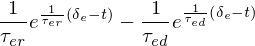

In [28]:
alpha_prime

In [29]:
theta_e = solve(alpha_prime, t)  # Time to peak

In [30]:
theta_e = logcombine(theta_e[0])

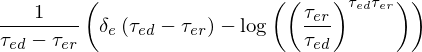

In [31]:
theta_e

In [32]:
simplify(theta_e.subs(averageEstimateDict))

In [33]:
alpha_star = simplify(alpha.subs(t, theta_e).doit())

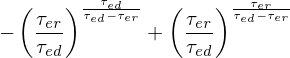

In [34]:
alpha_star

In [35]:
#alpha_star = simplify(alpha) # Replacing e_d/e_r with tau_e

### Finding maximum of the curve and substituting ratio of taus

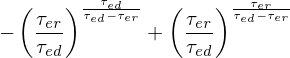

In [36]:
alpha_star

In [37]:
g_E = Piecewise((0. * nS, t / ms < delta_e / ms), (g_e * (alpha / alpha_star),
                                                   True))

### Final equation for Excitation normalized to be maximum at $g_e$

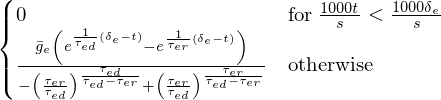

In [38]:
g_E

### Verifying that E Behaves

In [39]:
E_check = g_E.subs(averageEstimateDict).evalf()

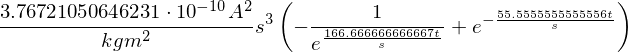

In [40]:
E_check

In [41]:
E_check.free_symbols

In [42]:
f = lambdify(
    (t), simplify(E_check / nS), modules=("sympy", "numpy", unitsDict))

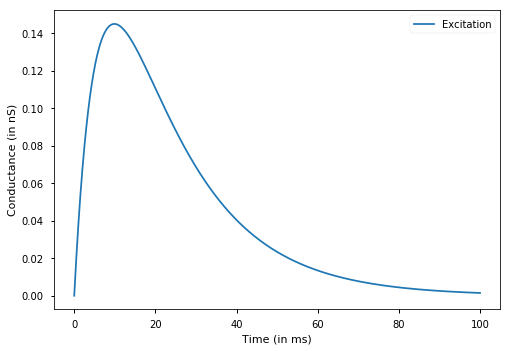

In [43]:
fig, ax = plt.subplots()
ax.plot(trange, [f(dt * ms) for dt in trange], label="Excitation")
ax.set_xlabel("Time (in ms)")
ax.set_ylabel("Conductance (in nS)")
ax.legend()

In [44]:
plt.close(fig)

### Doing the same with inhibition

In [45]:
g_I = g_E.xreplace({
    g_e: g_i,
    rho_e: rho_i,
    e_r: i_r,
    e_d: i_d,
    delta_e: delta_i
})

In [46]:
alpha_I = alpha.xreplace({e_r: i_r, e_d: i_d, delta_e: delta_i})
alpha_star_I = alpha_star.xreplace({e_r: i_r, e_d: i_d})

In [47]:
g_I = Piecewise((0. * nS, t / ms < delta_i / ms),
                (g_i * (alpha_I / alpha_star_I), True))

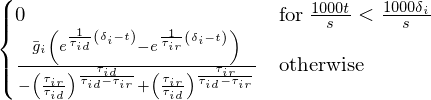

In [48]:
g_I

### Verifying that I Behaves

In [49]:
I_check = simplify(g_I.subs(averageEstimateDict).evalf())

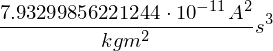

In [50]:
N(I_check.subs({t: 4.9 * ms}))

In [51]:
f = lambdify(t, simplify(I_check / nS), modules=("sympy", "numpy", unitsDict))

In [52]:
f(5 * ms)

array(0.0868746200026281, dtype=object)

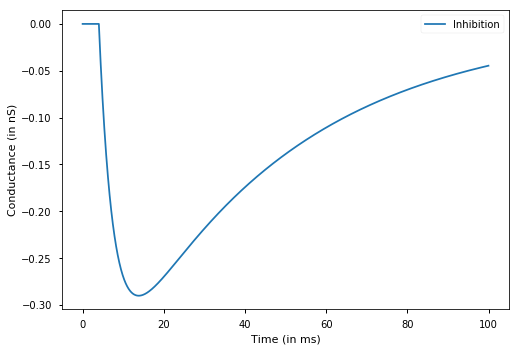

In [53]:
plt.plot(trange, [-f(dt * ms) for dt in trange], label="Inhibition")
plt.xlabel("Time (in ms)")
plt.ylabel("Conductance (in nS)")
plt.legend()
plt.show()

### Now finding the control peak using difference of these double-exponentials

In [54]:
compartment = Eq((1 / Cm) * (g_E * (Vm - e_rev) + g_I * (Vm - i_rev) + g_L *
                             (Vm - leak_rev)), Vm.diff(t))

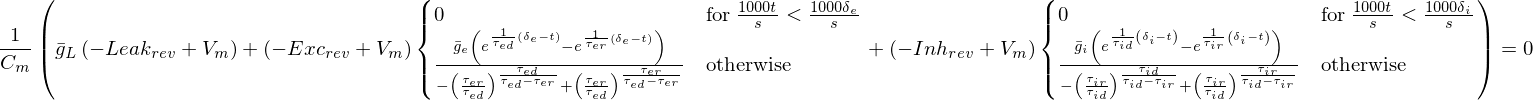

In [55]:
compartment

In [56]:
Vm_t = solve(compartment, Vm, rational=False, simplify=True)

In [57]:
check_vm_t = Vm_t[0].subs(averageEstimateDict).subs(approximateDict)/mV
vm_change = [check_vm_t.subs({t:dt*ms}) for dt in trange]

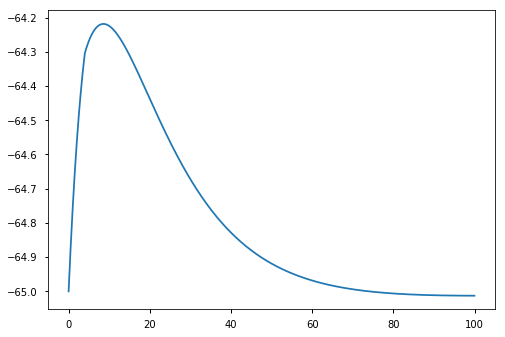

In [58]:
plt.plot(trange, vm_change)
plt.show()

### Sending to clusters

In [59]:
# symbols_to_pass = dict(t=t, P=P, e_r=e_r, e_d=e_d, delta_e=delta_e, rho_e=rho_e, g_e=g_e, i_r=i_r, i_d=i_d, delta_i=delta_i, rho_i=rho_i, g_i=g_i, b=b, Cm=Cm, g_L=g_L, leak_rev=leak_rev, e_rev=e_rev, i_rev=i_rev, Vm=Vm)
# units_to_pass = dict(nS=nS, pF=pF, mV=mV)
# expressions_to_pass = dict(Vm_t=Vm_t)

In [60]:
# dview.push(symbols_to_pass)
# dview.push(units_to_pass)
# dview.push(expressions_to_pass)
# dview.push(dict(unitsDict=unitsDict)) 

---

# Testing hypotheses

### Varying $g_e$ and proportionality $P$

In [61]:
check_vm_t = Vm_t[0].subs({ i: averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, P] }).subs(approximateDict).subs({ g_i: P * g_e })

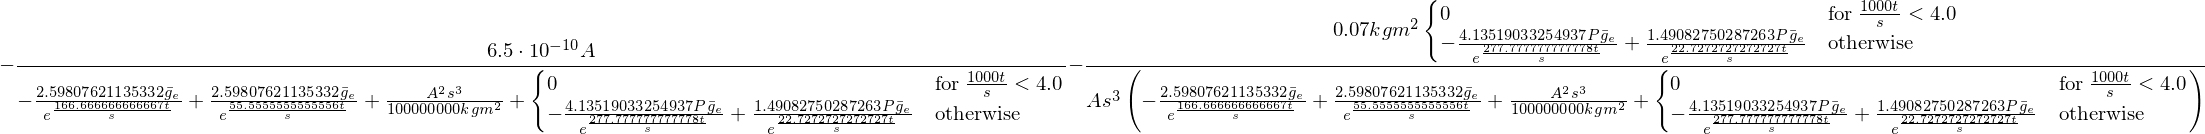

In [62]:
check_vm_t

In [63]:
f = lambdify((g_e, P, t), check_vm_t/mV, (unitsDict, "numpy"))

#### Case 1: No inhibition

In [64]:
prop = 0 # No inhibition
norm = matplotlib.colors.Normalize(
    vmin=numpy.min(erange),
    vmax=numpy.max(erange))
c_m = matplotlib.cm.viridis
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
s_m.set_array([])

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


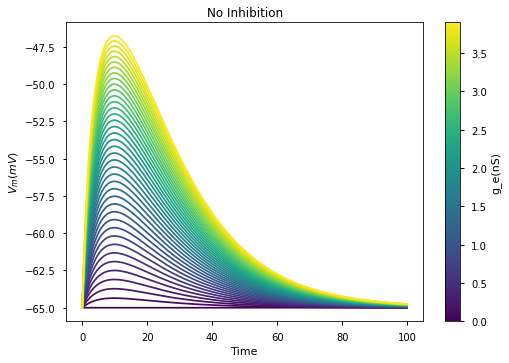

In [65]:
fig, ax = plt.subplots()
excitation_only = [] # Excitation only vector
for e in erange:
    e_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
    ax.plot(trange, e_t, color=s_m.to_rgba(e))
    excitation_only.append(e_t)
plt.xlabel("Time")
plt.ylabel("$V_m(mV)$")
plt.title("No Inhibition")
plt.colorbar(s_m, label="g_e(nS)")

In [66]:
numpy.savetxt('excitation_only.txt', excitation_only, header="0-{}:{}".format(emax, e_step))

#### Case 2: With inhibition proportional to excitation, or $g_i = P \times g_e$

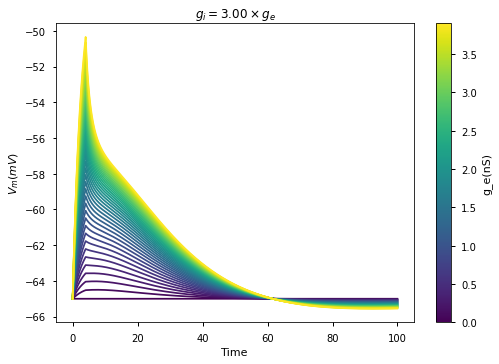

In [67]:
prop = 3.  # Proportionality
fig, ax = plt.subplots()
proportional_e_i = []
for e in erange:
#     dview.push(dict(e=e, prop=prop))
#     v_t = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)), trange)
    v_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
    proportional_e_i.append(v_t)
    ax.plot(trange, v_t, color=s_m.to_rgba(e))
plt.xlabel("Time")
plt.ylabel("$V_m(mV)$")
plt.title("$g_i = {:.2f} \\times g_e$".format(prop))
plt.colorbar(s_m, label="g_e(nS)")
plt.legend()

In [68]:
numpy.savetxt('excitation_inhibition_proportional_only.txt', proportional_e_i, header="0-{}:{}, P={}".format(emax, e_step, prop))

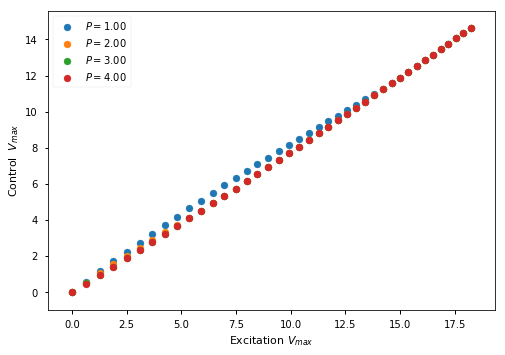

In [69]:
fig, ax = plt.subplots()
for prop in prop_array:
    v_max = []
    e_max = []
    for e, e_t in zip(erange, excitation_only):
        v_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
#         dview.push(dict(e=e, prop=prop))
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
    ax.scatter(e_max, v_max, label="$P= {:.2f}$".format(prop))
    numpy.savetxt('excitation_inhibition_proportional_{}_only_scatter.txt'.format(prop), (v_max, e_max), header="0-{}:{}, P={}".format(emax, e_step, prop))
ax.set_xlabel("Excitation $V_{max}$")
ax.set_ylabel("Control  $V_{max}$")
ax.legend()

#### Case 3: With inhibition recruited, $I = \frac{l}{1+\frac{1}{kE}}\times E$

In [70]:
p = lambda k,l: (k*l*e)/(1.+ (k*e))

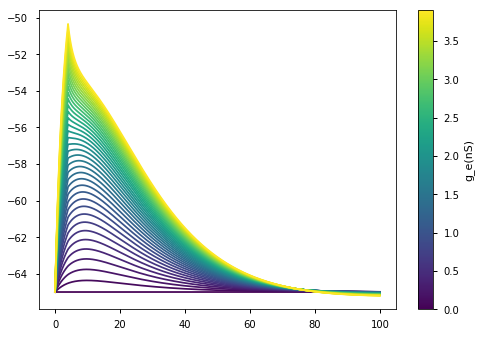

In [71]:
k, l = 1, 2
fig, ax = plt.subplots()
for e in erange:
    prop = p(k, l)
#     dview.push(dict(e=e, prop=prop))
    v_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
#     v_t = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)), trange)
    ax.plot(
        trange, v_t, color=s_m.to_rgba(e) )
plt.colorbar(s_m, label="g_e(nS)")
plt.legend()

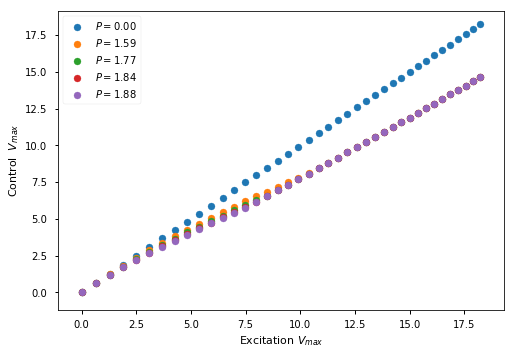

In [72]:
l = 2
fig, ax = plt.subplots()
for k in numpy.arange(0., 5., 1.):
    v_max = []
    e_max = []
    for e, e_t in zip(erange, excitation_only):
        prop = p(k, l)
        v_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        
#         dview.push(dict(e=e, prop=prop))
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
    ax.scatter(e_max, v_max, label="$P= {:.2f}$".format(prop))
    ax.set_xlabel("Excitation $V_{max}$")
    ax.set_ylabel("Control  $V_{max}$")
    numpy.savetxt('excitation_inhibition_divisive_recruited_only.txt', (e_max, v_max), header="0-{}:{}, k={},l={}".format(emax, e_step, k, l))
plt.legend()

## Changing kinetics as functions of the excitation.

### Changing $\delta_i$ = $\delta_{min}( 1 + \frac{1}{k\times{g_e}})$

In [74]:
d = lambda minDelay,k,e: minDelay*(1 + (1./(k*e)))

In [75]:
k, minDelay = 10, 1.5*ms

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """Entry point for launching an IPython kernel.


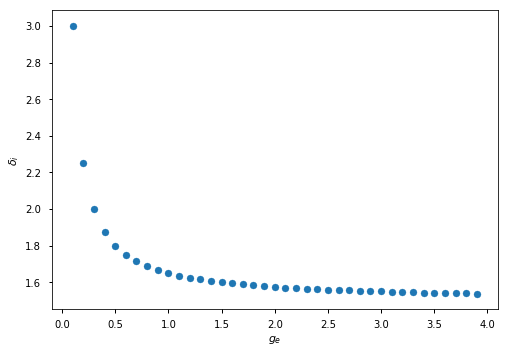

In [76]:
fig, ax = plt.subplots()
ax.scatter(erange, [d(minDelay, k, e) / ms for e in erange])
ax.set_xlabel("$g_e$")
ax.set_ylabel("$\\delta_i$")

### Changing $\delta_i$ = $\delta_{min} + me^{-k\times{g_e}}$

In [162]:
d = lambda minDelay,k,e: minDelay + m*exp(-(k*e))

In [169]:
nS = nano*siemens
k, m, minDelay = 2./nS, 9*ms, 1.*ms

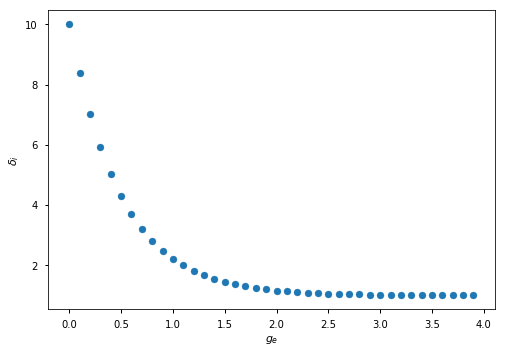

In [170]:
ax = plt.subplot()
ax.scatter(erange, [d(minDelay,k,e*nS)/ms for e in erange])
plt.xlabel("$g_e$")
plt.ylabel("$\\delta_i$")
plt.show()

In [171]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e, delta_i: d(minDelay,k,g_e)}).evalf())

In [172]:
f = lambdify((g_e, P, t), check_vm/mV, (unitsDict, "numpy"))

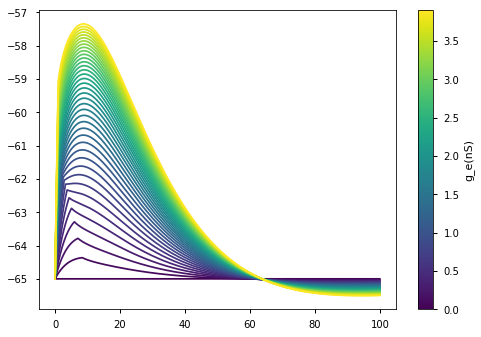

In [173]:
prop = 3.
ax = plt.subplot()
for e in erange:
#     dview.push(dict(e=e, prop=prop))
    v_t =  [float(f(e * nS, prop, dt * ms)) for dt in trange]
    #[float(f(e * nS, prop, dt * ms)) for dt in trange]
    delay = float(d(minDelay,k,e*nS)/ms)
#     v_t = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)), trange)
#     delay = float(dview['float(d(minDelay,k,e*nS)/ms)'][0])
    ax.plot(
        trange, v_t, color=s_m.to_rgba(e))
plt.colorbar(s_m, label="g_e(nS)")
plt.legend()

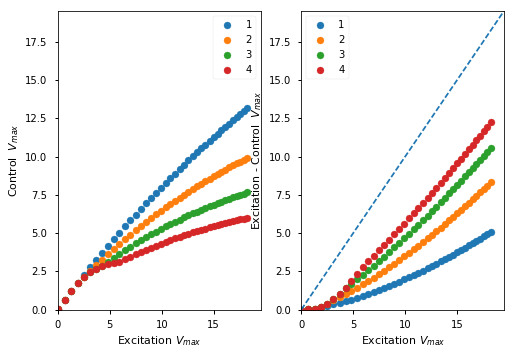

In [174]:
fig, ax = plt.subplots(1, 2)
for prop in prop_array:
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    for e, e_t in zip(erange, excitation_only):
#         dview.push(dict(e=e, prop=prop))
        v_t = [float(f(e * nS, prop, dt * ms)) for dt in trange]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))    
        
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
        v_ttp.append(numpy.argmax(v_t) * timeStep)
        e_ttp.append(numpy.argmax(e_t) * timeStep)
    e_max, v_max = numpy.array(e_max), numpy.array(v_max)
    ax[0].scatter(e_max, v_max, label=str(prop))
    ax[1].scatter(e_max, e_max - v_max, label=str(prop))
    #ax[1].scatter(e_ttp, v_ttp, label=str(p))
    numpy.savetxt('excitation_inhibition_proportional_{}_delay_scatter.txt'.format(prop), (v_max, e_max), header="0-{}:{}, P={}".format(emax, e_step, prop))
maxCoord = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[1].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[0].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[1].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $V_{max}$")
ax[1].set_ylabel("Excitation - Control  $V_{max}$")
#ax[1].set_xlabel("Excitation $t_{peak}$")
#ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

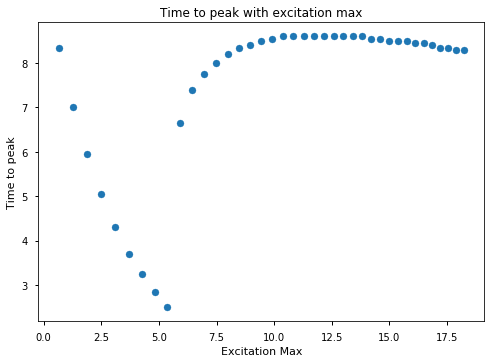

In [175]:
plt.scatter( e_max[1:], v_ttp[1:])
plt.title("Time to peak with excitation max")
plt.xlabel("Excitation Max")
plt.ylabel("Time to peak")
plt.show()

---

## Robustness testing of Divisive Normalization

### Divisive normalization is robust to 10% noise in proportionality between E and I.

In [ ]:
prop = 3.
delta_prop = numpy.linspace(-1,1,len(erange))
numpy.random.shuffle(delta_prop) # Randomizing order of change
ax = plt.subplot()
for index, e in enumerate(erange):
#     dview.push(dict(e=e, prop=prop))
    v_t = [float(f(e * nS, prop + delta_prop[index], dt * ms)) for dt in trange]
    delay = float(d(minDelay,k,e*nS)/ms)
#     v_t = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)), trange)
#     delay = float(dview['float(d(minDelay,k,e*nS)/ms)'][0])
    ax.plot(
        trange, v_t, color=s_m.to_rgba(e))
plt.colorbar(s_m, label="g_e(nS)")
plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 2)
delta_prop = numpy.linspace(0.9,1.1,len(erange))
for prop in prop_array:
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    numpy.random.shuffle(delta_prop) # Randomizing order of change
    for index, e in enumerate(erange):
#         dview.push(dict(e=e, prop=prop))
        v_t = [float(f(e * nS, prop * delta_prop[index], dt * ms)) for dt in trange]
        e_t = excitation_only[index]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        
        
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
        v_ttp.append(numpy.argmax(v_t) * timeStep)
        e_ttp.append(numpy.argmax(e_t) * timeStep)
    e_max, v_max = numpy.array(e_max), numpy.array(v_max)
    ax[0].scatter(e_max, v_max, label=str(prop))
    ax[1].scatter(e_max, e_max - v_max, label=str(prop))
    #ax[1].scatter(e_ttp, v_ttp, label=str(p))
maxCoord = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[1].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[0].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[1].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $V_{max}$")
ax[1].set_ylabel("Excitation - Control  $V_{max}$")
#ax[1].set_xlabel("Excitation $t_{peak}$")
#ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
plt.scatter( e_max[1:], v_ttp[1:])
plt.title("Time to peak with excitation max")
plt.xlabel("Excitation Max")
plt.ylabel("Time to peak")
plt.show()

### Permutation Test shows that Divisive Normalization cannot be achieved without E-I balance with just delays

In [ ]:
check_vm = Vm_t[0].subs({ i: averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, P] }).subs(approximateDict)

In [ ]:
f = lambdify((g_e, g_i, t), check_vm/mV, (unitsDict, "numpy"))

In [ ]:
fig, ax = plt.subplots(1, 2)
for prop in prop_array:
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    irange = prop*erange
    numpy.random.shuffle(irange)
    for index, e in enumerate(erange):
#         dview.push(dict(e=e, prop=prop))
        v_t = [float(f(e * nS, irange[index]* nS, dt * ms)) for dt in trange]
        e_t = excitation_only[index]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        
        
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
        v_ttp.append(numpy.argmax(v_t) * timeStep)
        e_ttp.append(numpy.argmax(e_t) * timeStep)
    e_max, v_max = numpy.array(e_max), numpy.array(v_max)
    ax[0].scatter(e_max, v_max, label=str(prop))
    ax[1].scatter(e_max, e_max - v_max, label=str(prop))
    #ax[1].scatter(e_ttp, v_ttp, label=str(p))
maxCoord = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[1].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[0].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[1].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $V_{max}$")
ax[1].set_ylabel("Excitation - Control  $V_{max}$")
#ax[1].set_xlabel("Excitation $t_{peak}$")
#ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
plt.scatter( e_max[1:], v_ttp[1:])
plt.title("Time to peak with excitation max")
plt.xlabel("Excitation Max")
plt.ylabel("Time to peak")
plt.show()

### Divisive normalization is robust to &plusmn; 10% change in delay.

In [ ]:
check_vm = simplify(Vm_t[0].subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e}).evalf())

In [ ]:
f = lambdify((g_e, P, delta_i, t), check_vm/mV, (unitsDict, "numpy"))

In [ ]:
fig, ax = plt.subplots(1, 2)
for prop in prop_array:
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    for index, e in enumerate(erange):
#         dview.push(dict(e=e, prop=prop))
        randomFactor = numpy.random.uniform(0.9,1.1)
        v_t = [float(f(e * nS, prop, d(minDelay,k,e*nS) * randomFactor, dt * ms)) for dt in trange]
        e_t = excitation_only[index]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        
        
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
        v_ttp.append(numpy.argmax(v_t) * timeStep)
        e_ttp.append(numpy.argmax(e_t) * timeStep)
    e_max, v_max = numpy.array(e_max), numpy.array(v_max)
    ax[0].scatter(e_max, v_max, label=str(prop))
    ax[1].scatter(e_max, e_max - v_max, label=str(prop))
    #ax[1].scatter(e_ttp, v_ttp, label=str(p))
maxCoord = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[1].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[0].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[1].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $V_{max}$")
ax[1].set_ylabel("Excitation - Control  $V_{max}$")
#ax[1].set_xlabel("Excitation $t_{peak}$")
#ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
plt.scatter( e_max[1:], v_ttp[1:])
plt.title("Time to peak with excitation max")
plt.xlabel("Excitation Max")
plt.ylabel("Time to peak")
plt.show()

### Permutation test shows that Divisive Normalization does not work with permuted delays for large values of excitation.

In [ ]:
fig, ax = plt.subplots(1, 2)
for prop in prop_array:
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    delayRange = [d(minDelay,k,e*nS) for e in erange]
    numpy.random.shuffle(delayRange)
    for index, e in enumerate(erange):
#         dview.push(dict(e=e, prop=prop))
        v_t = [float(f(e * nS, prop, delayRange[index], dt * ms)) for dt in trange]
        e_t = excitation_only[index]
        v_max.append(max(v_t) - float(approximateDict[leak_rev]/mV))
        e_max.append(max(e_t) - float(approximateDict[leak_rev]/mV))
        
        
#         vm_change = dview.map_sync(lambda dt: float(f(e * nS, prop, dt * ms)),
#                                    trange)
#         em_change = dview.map_sync(lambda dt: float(f(e * nS, 0., dt * ms)),
#                                    trange)
#         v_max.append(
#             max(vm_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
#         e_max.append(
#             max(em_change) - dview['float(approximateDict[leak_rev]/mV)'][0])
        v_ttp.append(numpy.argmax(v_t) * timeStep)
        e_ttp.append(numpy.argmax(e_t) * timeStep)
    e_max, v_max = numpy.array(e_max), numpy.array(v_max)
    ax[0].scatter(e_max, v_max, label=str(prop))
    ax[1].scatter(e_max, e_max - v_max, label=str(prop))
    #ax[1].scatter(e_ttp, v_ttp, label=str(p))
maxCoord = max(ax[0].get_xlim()[1], ax[0].get_ylim()[1])
ax[0].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[1].plot([0, 1], [0, 1], '--', transform=ax[1].transAxes)
ax[0].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[1].set(xlim=(0, maxCoord), ylim=(0, maxCoord))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $V_{max}$")
ax[1].set_ylabel("Excitation - Control  $V_{max}$")
#ax[1].set_xlabel("Excitation $t_{peak}$")
#ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
plt.scatter( e_max[1:], v_ttp[1:])
plt.title("Time to peak with excitation max")
plt.xlabel("Excitation Max")
plt.ylabel("Time to peak")
plt.show()

---

## Voltage clamping to see current responses.

In [131]:
I_t = (g_E * (Vm - e_rev) + g_I * (Vm - i_rev) + g_L *
                             (Vm - leak_rev))

In [134]:
I_t_check = I_t.subs({i:averageEstimateDict[i] for i in averageEstimateDict if i not in [g_e, g_i, delta_i]}).subs(approximateDict).subs({g_i: P*g_e})

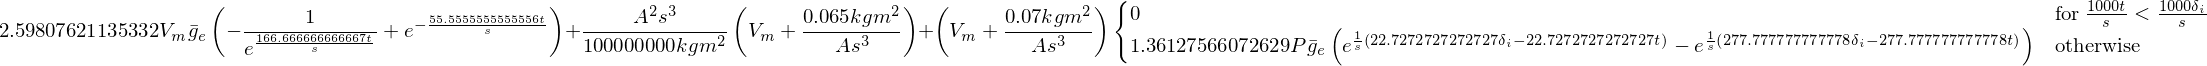

In [135]:
I_t_check

In [137]:
f = lambdify((Vm,P,g_e, delta_i,t), I_t_check/pA, (unitsDict, "numpy"))

### Clamping voltage at -40mv

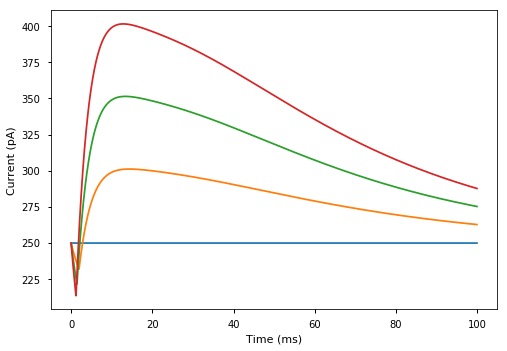

In [152]:
clamp_voltage = -40
prop = 3
delayRange = [d(minDelay,k,e*nS) for e in erange[::10]]
ax = plt.subplot()
for index, e in enumerate(erange[::10]):
    I_clamped_t = [float(f(clamp_voltage *mV, prop, e*nS, delayRange[index], dt * ms)) for dt in trange]
    ax.plot(trange, I_clamped_t)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")

### Clamping at -70

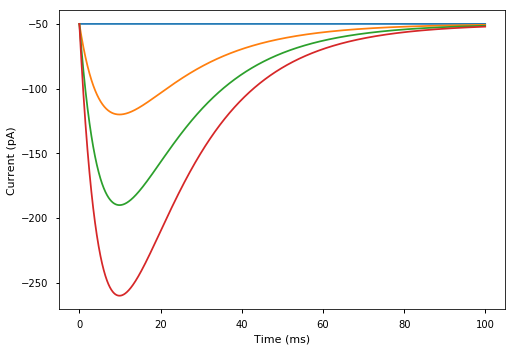

In [153]:
clamp_voltage = -70
prop = 3
delayRange = [d(minDelay,k,e*nS) for e in erange[::10]]
ax = plt.subplot()
for index, e in enumerate(erange[::10]):
    I_clamped_t = [float(f(clamp_voltage *mV, prop, e*nS, delayRange[index], dt * ms)) for dt in trange]
    ax.plot(trange, I_clamped_t)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")

### Clamping at 0 mV

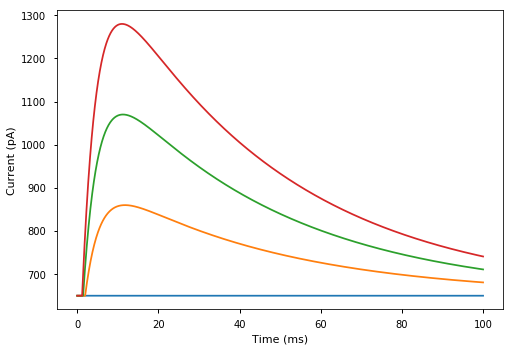

In [154]:
clamp_voltage = 0
prop = 3
delayRange = [d(minDelay,k,e*nS) for e in erange[::10]]
ax = plt.subplot()
for index, e in enumerate(erange[::10]):
    I_clamped_t = [float(f(clamp_voltage *mV, prop, e*nS, delayRange[index], dt * ms)) for dt in trange]
    ax.plot(trange, I_clamped_t)
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Current (pA)")

### Overplotting 0 and -40

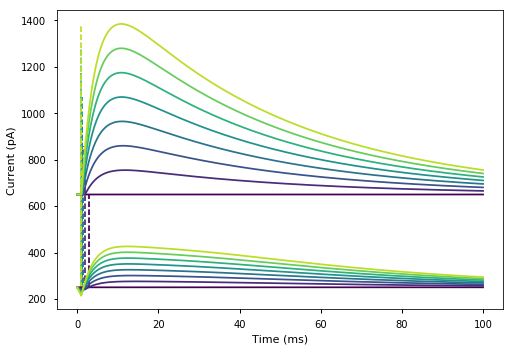

In [161]:
prop = 3
delayRange = [d(minDelay,k,e*nS) for e in erange[::5]]
ax = plt.subplot()
baseCurrent_0 = float(f(clamp_voltage *mV, 0, 0, 0, 0 * ms))
for index, e in enumerate(erange[::5]):
    clamp_voltage = 0
    delay = d(minDelay,k,e*nS)
    I_clamped_t = [float(f(clamp_voltage *mV, prop, e*nS, delay, dt * ms)) for dt in trange]
    ax.plot(trange, I_clamped_t, color=s_m.to_rgba(e))
    maxCurrent = numpy.max(I_clamped_t)
    clamp_voltage = -40
    I_clamped_t = [float(f(clamp_voltage *mV, prop, e*nS, delay, dt * ms)) for dt in trange]
    ax.plot(trange, I_clamped_t, color=s_m.to_rgba(e))
    minCurrent = numpy.min(I_clamped_t)
    ax.vlines(delay/ms, minCurrent,maxCurrent, color=s_m.to_rgba(e), linestyle='--')
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Current (pA)")

---

## <span style="color:red">  Try out the following: </span>
1. Estimate how many more synapses can be accommodated because of Divisive normalization before spiking. 
2. Check out spike time changes because of DN.

## Trying out other kinetic changes.

### Changing $\tau_{id} = k\times{g_e}$

In [ ]:
tp = lambda rise, decay: ((decay*rise)/(decay-rise))*log(decay/rise)

In [ ]:
k, rise = 10 * ms / nS, 3
plt.scatter(erange, [tp(rise, k * e * nS / ms) for e in erange])
plt.xlabel("$g_e$")
plt.ylabel("$t_{peak}$")
plt.show()

In [ ]:
check_vm = simplify(Vm_t[0].subs({
    i: averageEstimateDict[i]
    for i in averageEstimateDict if i not in [g_e, g_i, i_d]
}).subs(approximateDict).subs({
    g_i: P * g_e,
    i_d: k * g_e
})).evalf()

In [ ]:
f = lambdify((g_e, P, t), check_vm/mV, (unitsDict, "numpy"))

In [ ]:
for e in erange:
    plt.plot(
        trange, [f(e * nS, 1., dt * ms) for dt in trange],
        label="$g_e={}nS, \\delta_i={:.2f}ms$".format(e, k * e / nS))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2)
for p in np.arange(1, 4, 1):
    v_max = []
    e_max = []
    v_ttp = []
    e_ttp = []
    for e in erange:
        vm_change = [f(e * nS, p, dt * ms) for dt in trange]
        em_change = [f(e * nS, 0., dt * ms) for dt in trange]
        v_max.append(max(vm_change) - approximateDict[leak_rev] / mV)
        e_max.append(max(em_change) - approximateDict[leak_rev] / mV)
        v_ttp.append(np.argmax(vm_change) * timeStep)
        e_ttp.append(np.argmax(em_change) * timeStep)
    ax[0].scatter(e_max, v_max, label=str(p))
    ax[1].scatter(e_ttp, v_ttp, label=str(p))
ax[0].set_xlabel("Excitation $V_{max}$")
ax[0].set_ylabel("Control  $V_{max}$")
ax[1].set_xlabel("Excitation $t_{peak}$")
ax[1].set_ylabel("Control  $t_{peak}$")
ax[0].legend()
ax[1].legend()
plt.show()

In [ ]:
f(10,1,50)

In [ ]:
for new_P in np.arange(1, 3, 0.5):
    v_max = []
    for e in erange:
        f = lambdify(g_e, P, vm_change, "numpy")
        trange = np.arange(0, 200, 0.1)
        vm_change = [
            check_vm_t.subs({
                t: dt,
                g_e: new_g_e,
                P: new_P
            }) for dt in trange
        ]
        v_max.append(max(vm_change) - leak_rev.subs(approximateDict))
    plt.scatter(erange, v_max)
    plt.show()

In [ ]:
compartment.subs(averageEstimateDict).subs(approximateDict)

### Now trying to change parameters and look at how $V_m$ changes

In [ ]:
# 1. Get rid of the normalization factor.
# 2. The functions must approximate each other when close to 0.
# 3. The precision of the parameters in the equations must increase with g_e.

In [ ]:
g_e.subs(averageEstimateDict)

In [ ]:
A = Piecewise((0, t < delta_i), (exp(t/(2*ms)), True))

In [ ]:
A = A.subs({delta_i:10*ms})

In [ ]:
f = lambdify(t,A, {'s':seconds, 'exp':exp})